# Data Processing


In [1]:
%load_ext autoreload
%autoreload 2

import os
import sqlite3
import sys
import warnings
from datetime import date
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from data_check_utils import calculate_missing_stats
from data_prepare import createDB_bpm_and_factset_code
from database_utils import (
    get_table_names,
    step1_load_file_to_db,
    step2_create_variable_tables,
    step3_create_return_table,
)
from fredapi import Fred
from tqdm import tqdm

warnings.simplefilter("ignore")


Q_DIR = Path().cwd().parent.parent
DATA_DIR = Q_DIR / "data" / "MSCI_KOKUSAI"
PRJ_DIR = Q_DIR / "A_001"
# Factset Benchmark directory
BM_DIR = Q_DIR / "data/Factset/Benchmark"
FRED_DIR = Path().cwd().parents[2] / "FRED"
print(f"FRED directory: {FRED_DIR}")


fred_module = str((FRED_DIR / "src").resolve())
if fred_module not in sys.path:
    sys.path.append(fred_module)
    print(f"{fred_module}をsys.pathに追加しました。")

from fred_database_utils import store_fred_database  # type: ignore
from us_treasury import (
    plot_loadings_and_explained_variance,
    plot_us_interest_rates_and_spread,
)

FRED_API = os.getenv("FRED_API_KEY")

FRED directory: /Users/yukihata/Desktop/papers-1/FRED
/Users/yukihata/Desktop/papers-1/FRED/srcをsys.pathに追加しました。


## 0. Convert csv files into parquet files


In [ ]:
csv_files = sorted(list(DATA_DIR.glob("*.csv")))
for f in csv_files:
    df = pd.read_csv(f, encoding="utf-8")
    df.to_parquet(DATA_DIR / f"{f.stem}.parquet", index=False)

## 1. Create DB: MSCI_KOKUSAI_BPM_and_Factset_Code.db

-   ファイルは全てあるか
-   date, GICS sector ごとに銘柄数とウェイトをチェック
-   BPM からインデックスデータを取得し Factset の企業名とコードを付与した生データファイルを SQLite3 データベースに保存する


In [ ]:
# csv_files = sorted(list(DATA_DIR.glob("MSCI_KOKUSAI_Constituents*.csv")))
# dfs = [pd.read_csv(f, encoding="utf-8") for f in csv_files]
parquet_files = sorted(list(DATA_DIR.glob("MSCI_KOKUSAI_Constituents*.parquet")))
dfs = [pd.read_parquet(f) for f in parquet_files]

df = (
    pd.concat(dfs)
    .assign(date=lambda row: pd.to_datetime(row["date"]))
    .sort_values("date", ignore_index=True)
)

g1 = (
    df.groupby(["date"])["Weight (%)"]
    .agg(["count", "sum"])
    .rename(columns={"count": "num of secs", "sum": "total weight (%)"})
)
display(g1)
display(g1.describe())


g2 = (
    df.groupby(["date", "GICS Sector"])["Weight (%)"]
    .agg(["count", "sum"])
    .rename(columns={"count": "num of secs", "sum": "total weight (%)"})
)
display(g2)

# SQLite3データベース作成
db_name = DATA_DIR / "MSCI_KOKUSAI_BPM_and_Factset_Code.db"
createDB_bpm_and_factset_code(
    db_name=db_name, raw_data_list=parquet_files, file_type="parquet"
)

,num of secs,total weight (%)
date,,
2000-01-31,1065,100.000000
2000-02-29,1062,99.999994
2000-03-31,1057,100.000025
2000-04-30,1055,100.000019
2000-05-31,1046,100.000018
...,...,...
2025-03-31,1169,100.000006
2025-04-30,1169,99.999987
2025-05-31,1170,99.999988


,num of secs,total weight (%)
count,307.000000,307.000000
mean,1294.602606,100.000000
std,107.987404,0.000011
min,1023.000000,99.999963
25%,1271.500000,99.999993
50%,1309.000000,100.000000
75%,1329.000000,100.000006
max,1561.000000,100.000028


num of secs  total weight (%)
date       GICS Sector                                          
2000-01-31 Communication Services           32         11.771133
           Consumer Discretionary          187         13.164694
           Consumer Staples                 88          6.224660
           Energy                           38          5.651133
           Financials                      172         16.592643
...                                        ...               ...
2025-07-31 Industrials                     205         10.692579
           Information Technology          113         27.597718
           Materials                        82          3.130145
           Real Estate                      63          1.955128
           Utilities                        68          2.747642

[3177 rows x 2 columns]

日付: 2000-01-31 のデータをテーブル '2000_01_31' に書き込みました。
日付: 2000-02-29 のデータをテーブル '2000_02_29' に書き込みました。
日付: 2000-03-31 のデータをテーブル '2000_03_31' に書き込みました。
日付: 2000-04-30 のデータをテーブル '2000_04_30' に書き込みました。
日付: 2000-05-31 のデータをテーブル '2000_05_31' に書き込みました。
日付: 2000-06-30 のデータをテーブル '2000_06_30' に書き込みました。
日付: 2000-07-31 のデータをテーブル '2000_07_31' に書き込みました。
日付: 2000-08-31 のデータをテーブル '2000_08_31' に書き込みました。
日付: 2000-09-30 のデータをテーブル '2000_09_30' に書き込みました。
日付: 2000-10-31 のデータをテーブル '2000_10_31' に書き込みました。
日付: 2000-11-30 のデータをテーブル '2000_11_30' に書き込みました。
日付: 2000-12-31 のデータをテーブル '2000_12_31' に書き込みました。
日付: 2001-01-31 のデータをテーブル '2001_01_31' に書き込みました。
日付: 2001-02-28 のデータをテーブル '2001_02_28' に書き込みました。
日付: 2001-03-31 のデータをテーブル '2001_03_31' に書き込みました。
日付: 2001-04-30 のデータをテーブル '2001_04_30' に書き込みました。
日付: 2001-05-31 のデータをテーブル '2001_05_31' に書き込みました。
日付: 2001-06-30 のデータをテーブル '2001_06_30' に書き込みました。
日付: 2001-07-31 のデータをテーブル '2001_07_31' に書き込みました。
日付: 2001-08-31 のデータをテーブル '2001_08_31' に書き込みました。
日付: 2001-09-30 のデータをテーブル '2001_09_30' に書

## 2. Create financial database: MSCI_KOKUSAI_Factset_Financials.db

全ての元データファイルの csv を読み込んで sqlite に格納する。5 年前から 5 年後までの monthly のシフトデータ用カラムも追加する。


### 案 1


In [ ]:
def read_csv_with_date(file_path: Path):
    return pd.read_csv(file_path, encoding="utf-8", parse_dates=["date"])


# 全ての元データのcsvファイルを読み込み -> concat
csv_files = sorted(list(DATA_DIR.glob("Financials_all_data*.csv")))
dfs = [read_csv_with_date(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True).sort_values("date", ignore_index=True)

# monthlyでシフト
df_copy = df.copy().assign(date=lambda row: pd.to_datetime(row["date"]))
df_copy = (
    pd.pivot_table(
        df_copy, index=["date", "P_SYMBOL"], columns="variable", values="value"
    )
    .reset_index()
    .sort_values(["date", "P_SYMBOL"], ignore_index=True)
    .assign(date=lambda row: pd.to_datetime(row["date"].dt.strftime("%Y-%m-%d")))
)
shift_cols = [col for col in df_copy.columns if col not in ["P_SYMBOL", "date"]]

concat_df = df_copy.copy()
for shift_period in tqdm(range(1, 61)):
    shifted_values_past = (
        df_copy.groupby("P_SYMBOL")[shift_cols]
        .shift(periods=shift_period)
        .add_suffix(f"_{shift_period}M_ago")
    )
    shifted_values_future = (
        df_copy.groupby("P_SYMBOL")[shift_cols]
        .shift(periods=-shift_period)
        .add_suffix(f"_{shift_period}M_forward")
    )

    concat_df = pd.concat([concat_df, shifted_values_past], axis=1)
    concat_df = pd.concat([concat_df, shifted_values_future], axis=1)


# ----- export to database -----
db_name = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"

try:
    # データベースに接続（ファイルがなければ新規作成）
    conn = sqlite3.connect(db_name)

    # DataFrameからユニークな日付を取得
    unique_dates = df["date"].unique()

    # 各日付ごとにループ処理
    for date in unique_dates:
        # 現在のループの日付でDataFrameをフィルタリング
        df_quarterly = df[df["date"] == date]

        # 日付からテーブル名を作成
        table_name = f"{date.strftime('%Y_%m_%d')}"

        # date列のデータ型をstringに変更
        df_quarterly["date"] = pd.to_datetime(df_quarterly["date"]).dt.strftime(
            "%Y-%m-%d"
        )

        # DataFrameを対応するテーブルに書き込む
        # if_exists='replace': もし同名テーブルがあれば上書きする
        # index=False: DataFrameのインデックスをDBに保存しない
        df_quarterly.to_sql(table_name, conn, if_exists="replace", index=False)

        print(
            f"日付: {date.date()} のデータをテーブル '{table_name}' に書き込みました。"
        )

except sqlite3.Error as e:
    print(f"データベースエラー: {e}")
except Exception as e:
    print(f"エラーが発生しました: {e}")
finally:
    # 接続を閉じる
    if conn:
        conn.close()

### 案 2


In [ ]:
# --- ステップ1：生のCSVデータを一度だけデータベースに格納する ---
def step1_load_csv_to_db(csv_files, db_path):
    """
    全てのCSVファイルを読み込み、一つのテーブルに生のデータを格納する。
    この処理はメモリを最も使用するが、実行は最初の一度だけ。
    """
    print("--- ステップ1: CSVデータをデータベースにロード開始 ---")

    # メモリを節約するため、ジェネレータ式を使って少しずつ読み込みながら結合
    dfs_generator = (pd.read_csv(f, encoding="utf-8") for f in csv_files)
    df_raw = pd.concat(dfs_generator, ignore_index=True)

    # 不要なメモリを解放
    del dfs_generator

    df_raw["date"] = pd.to_datetime(df_raw["date"]).dt.strftime("%Y-%m-%d")

    try:
        conn = sqlite3.connect(db_path)
        # 生データを'raw_data'テーブルとして保存
        df_raw.to_sql("raw_data", conn, if_exists="replace", index=False)
        print(
            f"全CSVデータをデータベース '{db_path.name}' の 'raw_data' テーブルに保存しました。"
        )
    except Exception as e:
        print(f"ステップ1でエラーが発生しました: {e}")
    finally:
        if conn:
            conn.close()


# --- ステップ2：銘柄ごとに特徴量を作成し、最終テーブルに格納する ---
def step2_process_and_create_features(db_path):
    """
    銘柄ごとにデータを読み出し、シフト特徴量を「ロングフォーマット」で作成し、
    最終的な結果を新しいテーブルに格納する。
    """
    print("\n--- ステップ2: 銘柄ごとに特徴量を作成開始 (ロングフォーマット) ---")

    try:
        conn = sqlite3.connect(db_path)
        symbols = pd.read_sql_query("SELECT DISTINCT P_SYMBOL FROM raw_data", conn)[
            "P_SYMBOL"
        ].tolist()

        for i, symbol in enumerate(tqdm(symbols, desc="Processing Symbols")):
            # 銘柄一つ分のデータを読み込む
            query = f"SELECT * FROM raw_data WHERE P_SYMBOL = '{symbol}'"
            df_symbol = pd.read_sql_query(query, conn, parse_dates=["date"])

            # ピボット処理
            df_pivot = pd.pivot_table(
                df_symbol,
                index=["date", "P_SYMBOL"],
                columns="variable",
                values="value",
            ).reset_index()

            shift_cols = [
                col for col in df_pivot.columns if col not in ["P_SYMBOL", "date"]
            ]

            # --- ロングフォーマットでの特徴量生成 ---
            # 処理結果を格納するリスト
            all_features_long = []

            # 1. 元のデータをロングフォーマットに変換
            base_features = df_pivot.melt(
                id_vars=["date", "P_SYMBOL"],
                value_vars=shift_cols,
                var_name="feature_name",
                value_name="value",
            )
            all_features_long.append(base_features)

            # 2. シフト特徴量を生成し、同様にロングフォーマットで追加
            for shift_period in range(1, 61):
                # 過去へのシフト
                past_shift = df_pivot[shift_cols].shift(periods=shift_period)
                past_shift_long = pd.concat(
                    [df_pivot[["date", "P_SYMBOL"]], past_shift], axis=1
                ).melt(
                    id_vars=["date", "P_SYMBOL"],
                    value_vars=shift_cols,
                    var_name="feature_name",
                    value_name="value",
                )
                past_shift_long["feature_name"] += f"_{shift_period}M_ago"
                all_features_long.append(past_shift_long)

                # 未来へのシフト
                future_shift = df_pivot[shift_cols].shift(periods=-shift_period)
                future_shift_long = pd.concat(
                    [df_pivot[["date", "P_SYMBOL"]], future_shift], axis=1
                ).melt(
                    id_vars=["date", "P_SYMBOL"],
                    value_vars=shift_cols,
                    var_name="feature_name",
                    value_name="value",
                )
                future_shift_long["feature_name"] += f"_{shift_period}M_forward"
                all_features_long.append(future_shift_long)

            # 全てのロングフォーマットDFを一つに結合
            final_symbol_df_long = pd.concat(all_features_long, ignore_index=True)
            # NaN値を持つ行を削除（シフトによって生成されたもの）
            final_symbol_df_long.dropna(subset=["value"], inplace=True)

            # --- データベースへの書き込み ---
            write_mode = "replace" if i == 0 else "append"
            final_symbol_df_long.to_sql(
                "final_data_long_format", conn, if_exists=write_mode, index=False
            )

        print(
            "全銘柄の処理が完了し、'final_data_long_format' テーブルに保存されました。"
        )

    except Exception as e:
        print(f"ステップ2でエラーが発生しました: {e}")
    finally:
        if conn:
            conn.close()


csv_files = sorted(list(DATA_DIR.glob("Financials_all_data*.csv")))
db_name = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"

step1_load_csv_to_db(csv_files, db_name)
step2_process_and_create_features(db_name)

### 案 3: Polars


In [ ]:
# --- ステップ1：生のCSVデータをPolarsで直接DBに格納 ---
def step1_load_csv_to_db(csv_glob_path, db_uri):
    """
    Polarsを使い、全CSVを高速に読み込んでDBに格納する。
    """
    print("--- ステップ1: PolarsでCSVデータをロード開始 ---")
    try:
        df_raw = pl.read_csv(csv_glob_path)

        # 日付のフォーマットを統一
        df_raw = df_raw.with_columns(
            pl.col("date").str.to_datetime().dt.strftime("%Y-%m-%d")
        )

        # 'raw_data'テーブルとして保存
        df_raw.write_database("raw_data", db_uri, if_table_exists="replace")
        print("全CSVデータを 'raw_data' テーブルに保存しました。")
    except Exception as e:
        print(f"ステップ1でエラーが発生しました: {e}")


# # --- ステップ2：Polarsの並列処理で全特徴量を一気に生成 ---
# def step2_process_and_create_features(db_uri):
#     """
#     Polarsの能力を最大限に活用し、全シンボルの特徴量を一度に計算する。
#     """
#     print("\n--- ステップ2: Polarsで全特徴量を一括生成開始 ---")
#     try:
#         # PolarsとconnectorxでDBから高速に読み込み
#         df_raw = pl.read_database("SELECT * FROM raw_data", db_uri)

#         # 1. ピボット処理
#         df_pivot = df_raw.pivot(
#             index=["date", "P_SYMBOL"], columns="variable", values="value"
#         ).sort(["P_SYMBOL", "date"])

#         shift_cols = [
#             col for col in df_pivot.columns if col not in ["P_SYMBOL", "date"]
#         ]

#         # 2. シフト処理の「式(Expression)」をリストとして生成
#         shift_expressions = []
#         for col in shift_cols:
#             for p in range(1, 61):
#                 # 過去へのシフト式
#                 shift_expressions.append(
#                     pl.col(col).shift(p).over("P_SYMBOL").alias(f"{col}_{p}M_ago")
#                 )
#                 # 未来へのシフト式
#                 shift_expressions.append(
#                     pl.col(col).shift(-p).over("P_SYMBOL").alias(f"{col}_{p}M_forward")
#                 )

#         # 3. 全てのシフト式を一度に適用 (この処理が並列で実行される)
#         df_wide = df_pivot.with_columns(shift_expressions)

#         # 4. ワイドフォーマットからロングフォーマットへ変換
#         final_df_long = df_wide.melt(
#             id_vars=["date", "P_SYMBOL"],
#             variable_name="feature_name",
#             value_name="value",
#         ).drop_nulls()  # drop_nulls()でNaNの行を効率的に削除

#         # 5. 最終結果をDBに書き込み
#         final_df_long.write_database(
#             "final_data_polars", db_uri, if_table_exists="replace"
#         )

#         print(f"全銘柄の処理が完了し、'final_data_polars' テーブルに保存されました。")

#     except Exception as e:
#         print(f"ステップ2でエラーが発生しました: {e}")


csv_files = sorted(list(DATA_DIR.glob("Financials_all_data*.csv")))
csv_glob_path = str(DATA_DIR) + "/Financials_all_data*.csv"
db_name = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
db_connection_uri = f"sqlite:///{db_name}"

step1_load_csv_to_db(csv_files, db_connection_uri)
step2_process_and_create_features(db_connection_uri)

### 案 4: Step1 は pandas 処理、Step2 も Pandas 処理


In [ ]:
# --- ステップ1：生のデータを一度だけデータベースに格納する ---

# csv_files = sorted(list(DATA_DIR.glob("Financials_all_data*.csv")))
parquet_files = sorted(list(DATA_DIR.glob("Financials_all_data*.parquet")))
display(parquet_files[:5])
display(parquet_files[-6:])
print(len(parquet_files))
db_path = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"

step1_load_file_to_db(file_list=parquet_files, file_type="parquet", db_name=db_path)
# --- ステップ2：クエリを使ってvariableごとにテーブルを作成 ---
step2_create_variable_tables(db_name=db_path)
# --- ステップ3：リターンデータを格納するテーブルを作成 ---
step3_create_return_table(db_path=db_path)

[PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2005.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2006.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2007.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2008.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2009.parquet')]

[PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2020.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2021.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2022.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2023.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2024.parquet'),
 PosixPath('/Users/yukihata/Desktop/papers/Quants/data/MSCI_KOKUSAI/Financials_all_data_2025.parquet')]

21
--- ステップ1: 元データファイルをデータベースにロード開始 ---
(1/21) Financials_all_data_2005.parquet を読み込み中...
(2/21) Financials_all_data_2006.parquet を読み込み中...
(3/21) Financials_all_data_2007.parquet を読み込み中...
(4/21) Financials_all_data_2008.parquet を読み込み中...
(5/21) Financials_all_data_2009.parquet を読み込み中...
(6/21) Financials_all_data_2010.parquet を読み込み中...
(7/21) Financials_all_data_2011.parquet を読み込み中...
(8/21) Financials_all_data_2012.parquet を読み込み中...
(9/21) Financials_all_data_2013.parquet を読み込み中...
(10/21) Financials_all_data_2014.parquet を読み込み中...
(11/21) Financials_all_data_2015.parquet を読み込み中...
(12/21) Financials_all_data_2016.parquet を読み込み中...
(13/21) Financials_all_data_2017.parquet を読み込み中...
(14/21) Financials_all_data_2018.parquet を読み込み中...
(15/21) Financials_all_data_2019.parquet を読み込み中...
(16/21) Financials_all_data_2020.parquet を読み込み中...
(17/21) Financials_all_data_2021.parquet を読み込み中...
(18/21) Financials_all_data_2022.parquet を読み込み中...
(19/21) Financials_all_data_2023.parquet を読み込み中...


#### (ボツ?)


In [ ]:
db_path = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
db_uri = f"sqlite:///{db_path}"
variables = [
    s
    for s in get_table_names(db_uri=db_uri)
    if (s != "all_data") & ~(s.endswith("_processed"))
]
all_variables = get_table_names(db_uri=db_uri)
display(all_variables)

conn = sqlite3.connect(db_path)

for variable in tqdm(variables[:3]):
    query = f"""
        SELECT
            date,
            P_SYMBOL,
            value
        FROM
            '{variable}'
        WHERE
            variable NOT LIKE '%Mago%'
            AND variable NOT LIKE '%Mforward'
        """
    df = (
        pd.read_sql(sql=query, con=conn)
        .sort_values("date")
        .rename(columns={"value": variable})
    )

    for i in range(-60, 61):
        if i == 0:
            continue

        col_name = (
            f"{variable}_{abs(i)}Mago" if i > 0 else f"{variable}_{abs(i)}Mforward"
        )
        df[col_name] = df.groupby("P_SYMBOL")[variable].shift(i)

    df = pd.melt(
        df, id_vars=["date", "P_SYMBOL"], value_name="value", var_name="variable"
    )
    display(df)

    df.to_sql(
        name=f"{variable}_processed",
        con=conn,
        if_exists="replace",
        index=False,
        method="multi",
    )

conn.close()

## 3. Check Missing Values


In [ ]:
db_code = DATA_DIR / "MSCI_KOKUSAI_BPM_and_Factset_Code.db"
db_uri_code = f"sqlite:///{db_code}"
db_financials = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
db_uri_financials = f"sqlite:///{db_financials}"

tables_code = get_table_names(db_uri=db_uri_code)
tables_financials = get_table_names(db_uri=db_uri_financials)


conn = sqlite3.connect(db_code)
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(all_data);")
all_columns = [row[1] for row in cursor.fetchall()]
exclude_columns = [
    "Bloomberg Ticker",
    "BloombergID",
    "CODE_JP",
    "P_SYMBOL_SEDOL",
    "P_SYMBOL_CUSIP",
    "P_SYMBOL_ISIN",
    "FG_COMPANY_NAME_SEDOL",
    "FG_COMPANY_NAME_CUSIP",
    "FG_COMPANY_NAME_ISIN",
    "欠損状態",
]  # 除外するカラム
cols_to_select = [f'"{col}"' for col in all_columns if col not in exclude_columns]

select_clause = ", ".join(cols_to_select)
print(select_clause)
query = f"SELECT {select_clause} FROM 'all_data';"
df_code = pd.read_sql(sql=query, con=conn)
conn.close()
del cursor


conn = sqlite3.connect(db_financials)
missing_stats_dfs = []  # インデックス構成銘柄に対して欠損している銘柄数とウェイトを計算したデータフレームを格納
missing_stats_sector_dfs = []  # インデックス構成銘柄に対して欠損している銘柄数とウェイトをセクター別に計算したデータフレームを格納

for variable in tqdm([s for s in tables_financials if s != "all_data"]):
    query = f"""
    SELECT
        date,
        P_SYMBOL,
        value
    FROM
        '{variable}'
    """
    df_financials = pd.read_sql(sql=query, con=conn).rename(columns={"value": variable})
    df_financials = (
        df_financials.sort_values("date", ignore_index=True)
        .assign(year=lambda row: pd.to_datetime(row["date"]).dt.year)
        .assign(month=lambda row: pd.to_datetime(row["date"]).dt.month)
    )

    df_financials = pd.merge(
        df_financials,
        df_code.drop(columns=["date"]),
        on=["year", "month", "P_SYMBOL"],
        how="outer",
    ).dropna(subset=["date", "Weight (%)"], how="any", ignore_index=True)

    missing_stats = calculate_missing_stats(
        group_cols=["date"], df=df_financials, variable=variable
    )
    missing_stats_dfs.append(missing_stats)

    missing_stats_sector = calculate_missing_stats(
        group_cols=["date", "GICS Sector"], df=df_financials, variable=variable
    )
    missing_stats_sector_dfs.append(missing_stats_sector)


# export missing value report
missing_stats = pd.concat(missing_stats_dfs, ignore_index=True)
missing_stats_sector = pd.concat(missing_stats_sector_dfs, ignore_index=True)
missing_stats_report = DATA_DIR / "Factset_Financials_Missing_data_report.xlsx"
with pd.ExcelWriter(missing_stats_report) as writer:
    missing_stats.to_excel(writer, sheet_name="Index", index=False)
    missing_stats_sector.to_excel(writer, sheet_name="GICS Sector", index=False)

missing_stats.to_csv(
    DATA_DIR / "Factset_Financials_Missing_data_report.csv", index=False
)
missing_stats_sector.to_csv(
    DATA_DIR / "Factset_Financials_Missing_data_sector_report.csv", index=False
)

['Name', 'Bloomberg Ticker', 'BloombergID', 'Asset ID', 'Asset ID Type', 'CODE_JP', 'CUSIP', 'SEDOL', 'ISIN', 'GICS Sector', 'GICS Industry', 'GICS Industry Group', 'GICS Sub-Industry', 'Holdings', 'Weight (%)', 'Mkt Value', 'date', 'FG_COMPANY_NAME_SEDOL', 'P_SYMBOL_SEDOL', 'FG_COMPANY_NAME_CUSIP', 'P_SYMBOL_CUSIP', 'FG_COMPANY_NAME_ISIN', 'P_SYMBOL_ISIN', 'FG_COMPANY_NAME', 'P_SYMBOL', '欠損状態', 'year', 'month']
"Name", "Asset ID", "Asset ID Type", "CUSIP", "SEDOL", "ISIN", "GICS Sector", "GICS Industry", "GICS Industry Group", "GICS Sub-Industry", "Holdings", "Weight (%)", "Mkt Value", "date", "FG_COMPANY_NAME", "P_SYMBOL", "year", "month"


100%|██████████| 64/64 [02:33<00:00,  2.40s/it]


## 4. Create Benchmark databse: Factset_BM.db


In [ ]:
# read raw files and conatenate
sheet_names = pd.ExcelFile(BM_DIR / "Benchmark_Price_and_Valuation.xlsx").sheet_names
dfs = []
for sheet_name in sheet_names:
    df = pd.read_excel(
        BM_DIR / "Benchmark_Price_and_Valuation.xlsx", sheet_name=sheet_name
    ).dropna(subset=["date"], ignore_index=True)
    df_melt = (
        pd.melt(
            df,
            id_vars="date",
            var_name="Benchmark",
            value_name="value",  # type: ignore
        )
        .assign(variable=sheet_name)
        .reindex(columns=["date", "Benchmark", "variable", "value"])
    )

    dfs.append(df_melt)

df = pd.concat(dfs, ignore_index=True)
df["value"] = df["value"].astype(float)

display(df)

# export
db_path = BM_DIR / "Benchmark_Price_and_Valuation.db"
conn = sqlite3.connect(db_path)
for benchmark in df["Benchmark"].unique():
    df_benchmark = df[df["Benchmark"] == benchmark]
    df_benchmark.to_sql(name=benchmark, con=conn, index=False)

,date,Benchmark,variable,value
0,2005-08-31,MSCI Kokusai Index (World ex Japan),FG_PRICE,1087.478462
1,2005-09-30,MSCI Kokusai Index (World ex Japan),FG_PRICE,1111.255847
2,2005-10-31,MSCI Kokusai Index (World ex Japan),FG_PRICE,1084.825110
3,2005-11-30,MSCI Kokusai Index (World ex Japan),FG_PRICE,1124.506153
4,2005-12-30,MSCI Kokusai Index (World ex Japan),FG_PRICE,1140.950652
...,...,...,...,...
3835,2025-03-31,S&P 500,FMA_EPS,277.588592
3836,2025-04-30,S&P 500,FMA_EPS,275.467865
3837,2025-05-30,S&P 500,FMA_EPS,277.199090
3838,2025-06-30,S&P 500,FMA_EPS,280.279247


### Data check(Plot price and valuation)


In [ ]:
benchmark = "MSCI Kokusai Index (World ex Japan)"
# benchmark = "S&P 500"
db_path = BM_DIR / "Benchmark_Price_and_Valuation.db"
conn = sqlite3.connect(db_path)
df = pd.pivot(
    pd.read_sql(sql=f"SELECT * FROM '{benchmark}'", con=conn),
    index="date",
    columns="variable",
    values="value",
).sort_index()
df.index = pd.to_datetime(df.index)

variables = df.columns.tolist()

fig, axes = plt.subplots(6, 1, figsize=(12, 8), tight_layout=True, sharex=True)
fig.suptitle(benchmark)
for i, variable in enumerate(
    [
        s
        for s in variables
        if s not in ["FMA_EVAL_EBIT", "FMA_EVAL_EBITDA", "FMA_EVAL_SALES"]
    ]
):
    ax = axes[i]
    ax.set_ylabel(variable)
    sns.lineplot(df, x=df.index, y=df[variable], ax=ax)
    ax.grid(axis="y")

for variable in ["FMA_EVAL_EBIT", "FMA_EVAL_EBITDA", "FMA_EVAL_SALES"]:
    ax = axes[5]
    ax.set_ylabel(variable)
    sns.lineplot(df, x=df.index, y=df[variable], ax=ax, label=variable)
    ax.legend(loc="lower left")
    ax.grid(axis="y")


# 2. X軸の目盛り
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
# 3. X軸のラベル
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# plt.show()
plt.savefig(BM_DIR / f"{benchmark}_prce_and_valuation.png", dpi=300)
plt.close()

## 5. Daily Price data(universe securities and benchmarks)


In [ ]:
# Factsetで取得した、ユニバースとベンチマークのdaily priceデータ
# Bloomberg FILEの容量制限のため、複数ファイルにparquetとして保存したものを確認する

# インデックス構成銘柄のプライスデータ
file_list = sorted(list(DATA_DIR.glob("MSCI_KOKUSAI_Price*.parquet")))
dfs = [pd.read_parquet(file) for file in file_list]
df = pd.concat(dfs, ignore_index=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values(["P_SYMBOL", "date"], ignore_index=True)

# store in a database
db_path = DATA_DIR / "MSCI_KOKUSAI_Price_Daily.db"
conn = sqlite3.connect(db_path)
df.to_sql(name="FG_PRICE_Daily", con=conn, if_exists="replace", index=False)
conn.close()

In [ ]:
# benchmark
file_path = BM_DIR / "Benchmark_Price.parquet"
df = pd.read_parquet(file_path)
df["date"] = pd.to_datetime(df["date"])
df.sort_values(["P_SYMBOL", "date"], ignore_index=True)

# store in a database
db_path = BM_DIR / "BM_Price_Daily.db"
conn = sqlite3.connect(db_path)
df.to_sql(name="FG_PRICE_Daily", con=conn, if_exists="replace", index=False)
conn.close()

## Check


In [ ]:
# def get_table_names(db_path: Path) -> list[str]:
#     table_names = []
#     try:
#         with sqlite3.connect(db_path) as conn:
#             cursor = conn.cursor()
#             query = "select name from sqlite_master where type='table';"
#             cursor.execute(query)
#             tables = cursor.fetchall()
#             table_names = [table[0] for table in tables]
#     except sqlite3.Error as e:
#         print(f"データベースエラーが発生: {e}")
#     except Exception as e:
#         print(f"予期せぬエラーが発生: {e}")

#     return table_names


code_db = DATA_DIR / "MSCI_KOKUSAI_BPM_and_Factset_Code.db"
code_db_date_list = get_table_names(code_db)
financials_db = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
financials_db_date_list = get_table_names(financials_db)
# display(financials_db_date_list[0])

for d in financials_db_date_list[40:41]:
    with sqlite3.connect(code_db) as conn:
        df_code = pd.read_sql_query(f"SELECT * FROM '{d}'", conn)
    with sqlite3.connect(financials_db) as conn:
        df_financials = pd.read_sql_query(f"SELECT * FROM '{d}'", conn)

    df_financials = (
        pd.pivot_table(
            df_financials,
            index=["date", "P_SYMBOL"],
            columns="variable",
            values="value",
        )
        .reset_index()
        .sort_values("date", ignore_index=True)
    )

    # display(df_code)
    display(df_financials)

    merged_df = pd.merge(
        df_financials,
        df_code[["date", "P_SYMBOL", "GICS Sector", "GICS Industry", "Weight (%)"]],
        on=["date", "P_SYMBOL"],
        how="left",
    ).dropna(subset="Weight (%)")
    print(f"df_code: {df_code.shape} --> merged_df: {merged_df.shape}")

    display(merged_df)

    display(merged_df["Weight (%)"].sum())

## FRED Economic data


### Download data and store in FRED database


In [ ]:
db_path = FRED_DIR / "FRED.db"
yield_data = [
    "DFF",  # FF金利（実行金利）
    "DGS1MO",  # 1 month
    "DGS3MO",  # 3 month
    "DGS6MO",  # 6 month
    "DGS1",  # 1 year
    "DGS2",  # 2 year
    "DGS3",  # 3 year
    "DGS5",  # 5 year
    "DGS7",  # 7 year
    "DGS10",  # 10 year
    "DGS20",  # 20 year
    "DGS30",  # 30 year
]

spread = ["T10Y2Y", "T10Y3M"]
store_fred_database(db_path=db_path, series_id_list=yield_data + spread)

--- FREDデータをデータベース 'FRED' に保存開始 ---
FREDシリーズ 'DFF' を取得中...
シリーズ 'DFF' をテーブル 'DFF' に保存しました。
FREDシリーズ 'DGS1MO' を取得中...
シリーズ 'DGS1MO' をテーブル 'DGS1MO' に保存しました。
FREDシリーズ 'DGS3MO' を取得中...
シリーズ 'DGS3MO' をテーブル 'DGS3MO' に保存しました。
FREDシリーズ 'DGS6MO' を取得中...
シリーズ 'DGS6MO' をテーブル 'DGS6MO' に保存しました。
FREDシリーズ 'DGS1' を取得中...
シリーズ 'DGS1' をテーブル 'DGS1' に保存しました。
FREDシリーズ 'DGS2' を取得中...
シリーズ 'DGS2' をテーブル 'DGS2' に保存しました。
FREDシリーズ 'DGS3' を取得中...
シリーズ 'DGS3' をテーブル 'DGS3' に保存しました。
FREDシリーズ 'DGS5' を取得中...
シリーズ 'DGS5' をテーブル 'DGS5' に保存しました。
FREDシリーズ 'DGS7' を取得中...
シリーズ 'DGS7' をテーブル 'DGS7' に保存しました。
FREDシリーズ 'DGS10' を取得中...
シリーズ 'DGS10' をテーブル 'DGS10' に保存しました。
FREDシリーズ 'DGS20' を取得中...
シリーズ 'DGS20' をテーブル 'DGS20' に保存しました。
FREDシリーズ 'DGS30' を取得中...
シリーズ 'DGS30' をテーブル 'DGS30' に保存しました。
FREDシリーズ 'T10Y2Y' を取得中...
シリーズ 'T10Y2Y' をテーブル 'T10Y2Y' に保存しました。
FREDシリーズ 'T10Y3M' を取得中...
シリーズ 'T10Y3M' をテーブル 'T10Y3M' に保存しました。
--- 全てのFREDデータをデータベース 'FRED' に保存完了 ---


### Plot Spread and Interest Rate


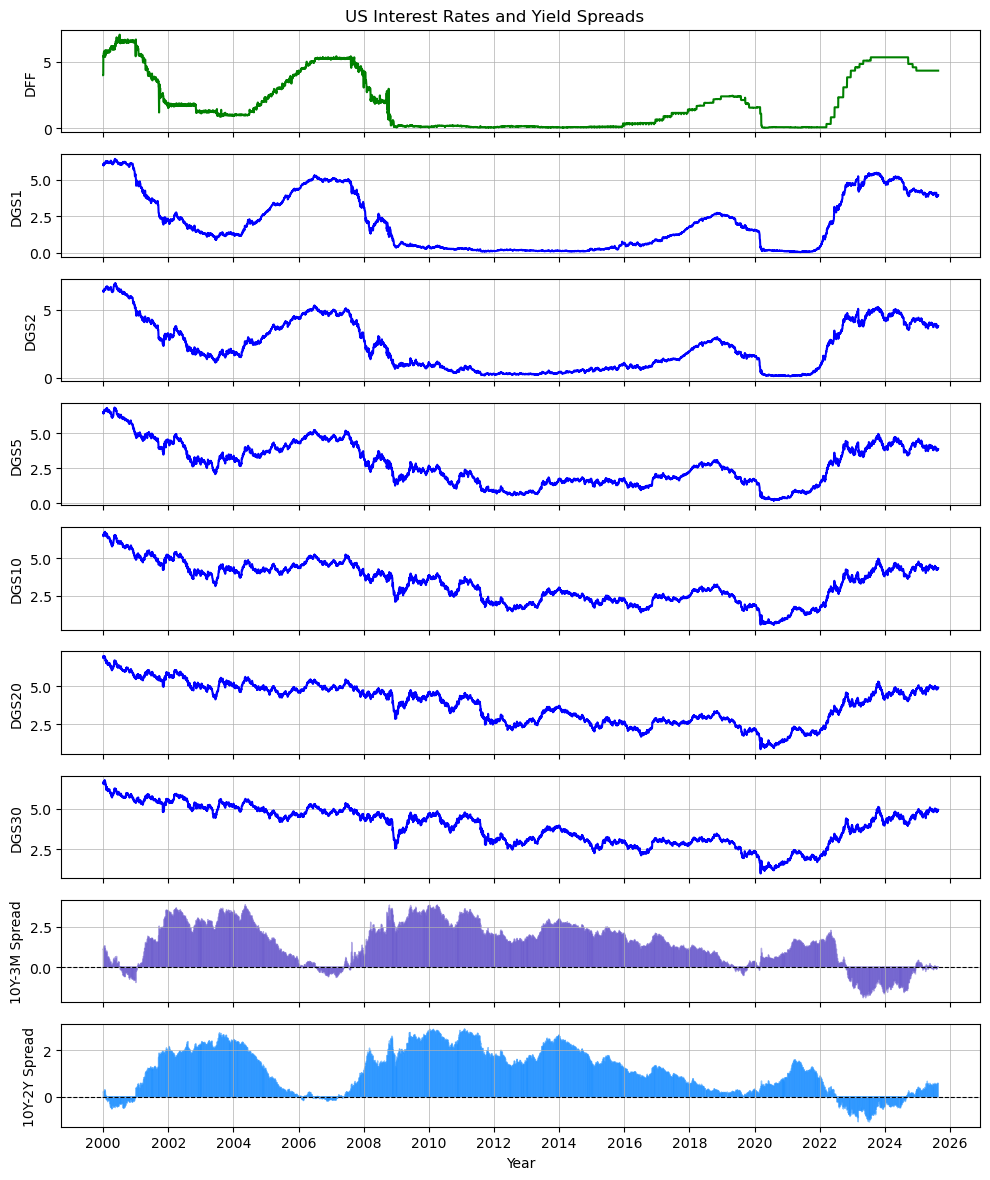

In [ ]:
db_path = FRED_DIR / "FRED.db"
plot_us_interest_rates_and_spread(db_path=db_path)

### Leve, Slope, Curvature(PCA analysis)


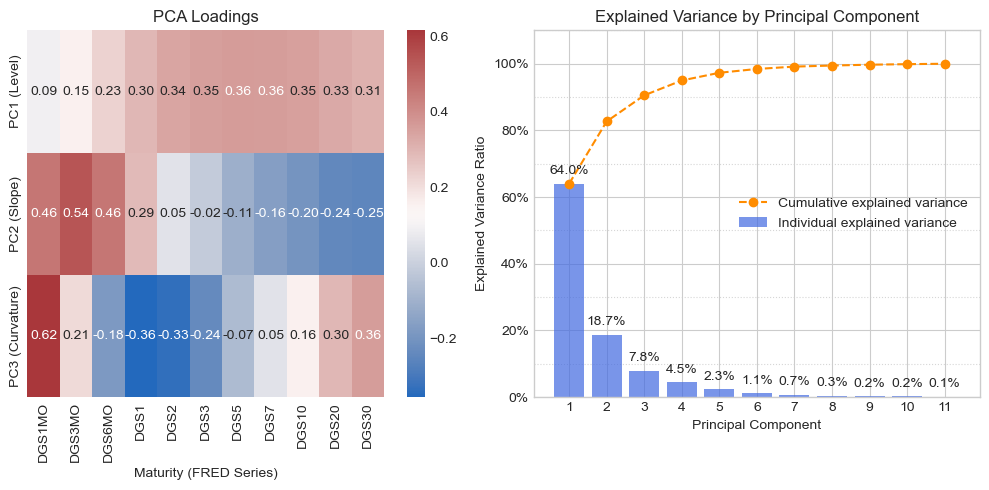

In [ ]:
# load interest rate data
series_id_list = [
    "DGS1MO",
    "DGS3MO",
    "DGS6MO",
    "DGS1",
    "DGS2",
    "DGS3",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS20",
    "DGS30",
]
conn = sqlite3.connect(FRED_DIR / "FRED.db")

dfs = []
for series_id in series_id_list:
    df = (
        pd.read_sql(sql=f"SELECT * FROM '{series_id}'", con=conn)
        .rename(columns={series_id: "value"})
        .assign(variable=series_id)
    )
    dfs.append(df)

df = pd.pivot(
    pd.concat(dfs, ignore_index=True),
    index="date",
    values="value",
    columns="variable",
).sort_index()
df.index = pd.to_datetime(df.index)
df = df.reindex(columns=series_id_list)
plot_loadings_and_explained_variance(df)

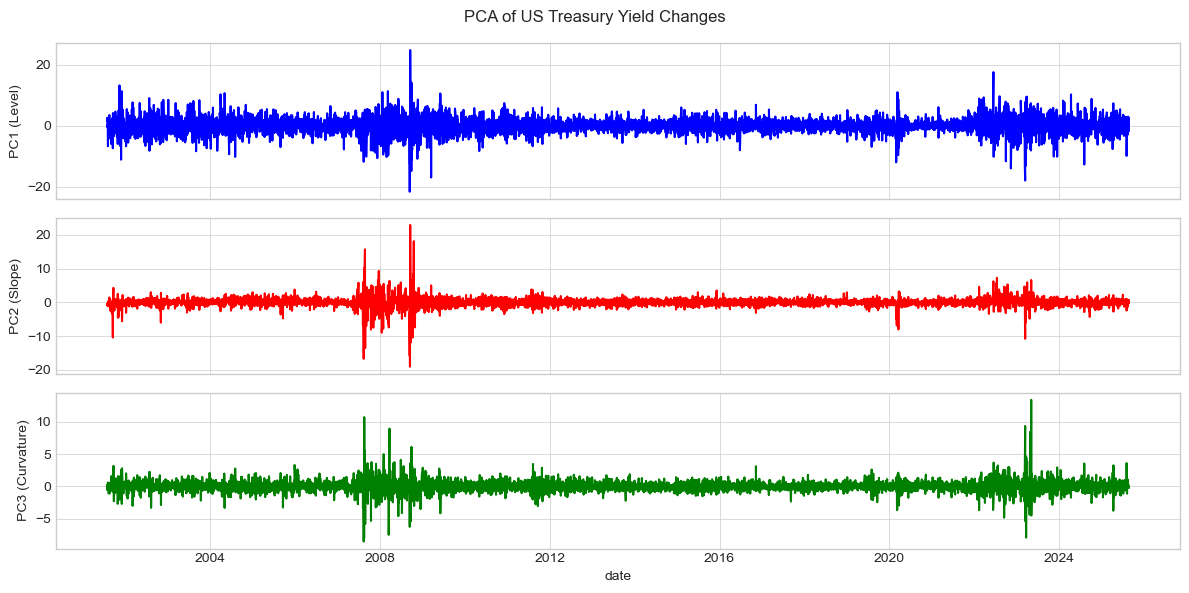

In [ ]:
# plot
fig, axes = plt.subplots(3, 1, figsize=(12, 6), tight_layout=True, sharex=True)
fig.suptitle("PCA of US Treasury Yield Changes")
ax1 = axes[0]
sns.lineplot(pd_df, x=pd_df.index, y="PC1 (Level)", ax=ax1, color="blue")
ax1.grid(linewidth=0.5)
ax2 = axes[1]
sns.lineplot(pd_df, x=pd_df.index, y="PC2 (Slope)", ax=ax2, color="red")
ax2.grid(linewidth=0.5)
ax3 = axes[2]
sns.lineplot(pd_df, x=pd_df.index, y="PC3 (Curvature)", ax=ax3, color="green")
ax3.grid(linewidth=0.5)
plt.show()

## Financials -> Rank


### Make Return data


In [ ]:
db_path = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql(sql="SELECT * FROM Return", con=conn)
display(df)

,date,P_SYMBOL,variable,value
0,2005-08-31,0HSW-GB,Return_1M,NaN
1,2005-09-30,0HSW-GB,Return_1M,0.120144
2,2005-10-31,0HSW-GB,Return_1M,0.158186
3,2005-11-30,0HSW-GB,Return_1M,0.015979
4,2005-12-30,0HSW-GB,Return_1M,0.021562
...,...,...,...,...
9394555,2025-03-31,ZURN-CH,Return_5YForward,NaN
9394556,2025-04-30,ZURN-CH,Return_5YForward,NaN
9394557,2025-05-30,ZURN-CH,Return_5YForward,NaN
9394558,2025-06-30,ZURN-CH,Return_5YForward,NaN


### Make rank data tables


In [ ]:
db_path = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
conn = sqlite3.connect(db_path)
# variables = [s for s in get_table_names(db_path=db_path) if s.startswith("FF_")]


# Financials
variable = "FF_ROIC"
df = (
    pd.read_sql(f"SELECT * FROM '{variable}'", con=conn, parse_dates=["date"])
    .assign(
        year=lambda row: row["date"].dt.year, month=lambda row: row["date"].dt.month
    )
    .drop(columns="variable")
)

# code and weight
db_path = DATA_DIR / "MSCI_KOKUSAI_BPM_and_Factset_Code.db"
conn = sqlite3.connect(db_path)
df_code = pd.read_sql(sql="SELECT * FROM all_data", con=conn)

df = pd.merge(
    df, df_code[["year", "month", "P_SYMBOL", "Weight (%)", "GICS Sector"]], how="left"
).dropna(subset=["Weight (%)"])


df[f"{variable}_rank_universe"] = (
    df.groupby("date")["value"]
    .transform(
        lambda x: (
            (pd.qcut(x, q=5, labels=False, duplicates="drop") + 1)
            if x.notna().sum() >= 5
            else pd.Series(np.nan, index=x.index)
        )
    )
    .replace(
        {
            1.0: "rank5",
            2.0: "rank4",
            3.0: "rank3",
            4.0: "rank2",
            5.0: "rank1",
        }
    )
)

df[f"{variable}_rank_sector"] = (
    df.groupby(["date", "GICS Sector"])["value"]
    .transform(
        lambda x: (
            (pd.qcut(x, q=5, labels=False, duplicates="drop") + 1)
            if x.notna().sum() >= 5
            else pd.Series(np.nan, index=x.index)
        )
    )
    .replace(
        {
            1.0: "rank5",
            2.0: "rank4",
            3.0: "rank3",
            4.0: "rank2",
            5.0: "rank1",
        }
    )
)

df.rename(columns={"value": variable}, inplace=True)
display(df)

# merge return dataframe

db_path = DATA_DIR / "MSCI_KOKUSAI_Factset_Financials.db"
conn = sqlite3.connect(db_path)
df_return = pd.pivot(
    pd.read_sql(sql="SELECT * FROM Return", con=conn, parse_dates=["date"]),
    index=["date", "P_SYMBOL"],
    columns="variable",
    values="value",
).reset_index()


df = pd.merge(df, df_return, on=["date", "P_SYMBOL"], how="left")
display(df)

,date,P_SYMBOL,FF_ROIC,year,month,Weight (%),GICS Sector,FF_ROIC_rank_universe,FF_ROIC_rank_sector
0,2005-08-31,0HSW-GB,-4.101327,2005,8,0.005496,Information Technology,rank5,rank5
1,2005-09-30,0HSW-GB,0.000000,2005,9,0.005968,Information Technology,rank5,rank5
2,2005-10-31,0HSW-GB,0.000000,2005,10,0.007202,Information Technology,rank5,rank5
3,2005-11-30,0HSW-GB,0.000000,2005,11,0.006999,Information Technology,rank5,rank5
4,2005-12-30,0HSW-GB,NaN,2005,12,0.006975,Information Technology,NaN,NaN
...,...,...,...,...,...,...,...,...,...
782898,2025-03-31,ZURN-CH,15.012054,2025,3,0.157954,Financials,rank2,rank1
782899,2025-04-30,ZURN-CH,15.012054,2025,4,0.160262,Financials,rank2,rank1
782900,2025-05-30,ZURN-CH,15.012054,2025,5,0.150137,Financials,rank2,rank1
782901,2025-06-30,ZURN-CH,15.613472,2025,6,0.143155,Financials,rank2,rank1


,date,P_SYMBOL,FF_ROIC,year,month,Weight (%),GICS Sector,FF_ROIC_rank_universe,FF_ROIC_rank_sector,Return_1M,...,Return_1Y,Return_1YForward,Return_3M,Return_3MForward,Return_3Y,Return_3YForward,Return_5Y,Return_5YForward,Return_6M,Return_6MForward
0,2005-08-31,0HSW-GB,-4.101327,2005,8,0.005496,Information Technology,rank5,rank5,NaN,...,NaN,-0.436327,NaN,-0.294309,NaN,NaN,NaN,NaN,NaN,-0.335712
1,2005-09-30,0HSW-GB,0.000000,2005,9,0.005968,Information Technology,rank5,rank5,0.120144,...,NaN,-0.328134,NaN,-0.195727,NaN,NaN,NaN,NaN,NaN,-0.327144
2,2005-10-31,0HSW-GB,0.000000,2005,10,0.007202,Information Technology,rank5,rank5,0.158186,...,NaN,-0.151966,NaN,-0.053573,NaN,NaN,NaN,NaN,NaN,-0.165981
3,2005-11-30,0HSW-GB,0.000000,2005,11,0.006999,Information Technology,rank5,rank5,0.015979,...,NaN,-0.092726,0.294309,-0.041403,NaN,NaN,NaN,NaN,NaN,-0.164802
4,2005-12-30,0HSW-GB,NaN,2005,12,0.006975,Information Technology,NaN,NaN,0.021562,...,NaN,-0.066416,0.195727,-0.131417,NaN,NaN,NaN,NaN,NaN,-0.162639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318321,2025-03-31,ZURN-CH,15.012054,2025,3,0.157954,Financials,rank2,rank1,0.035417,...,0.234797,NaN,0.132278,0.103375,0.297377,NaN,0.582726,NaN,0.187604,NaN
318322,2025-04-30,ZURN-CH,15.012054,2025,4,0.160262,Financials,rank2,rank1,-0.054465,...,0.270883,NaN,0.050354,0.045311,0.267063,NaN,0.639333,NaN,0.131179,NaN
318323,2025-05-30,ZURN-CH,15.012054,2025,5,0.150137,Financials,rank2,rank1,-0.008969,...,0.197615,NaN,-0.028017,NaN,0.275970,NaN,0.623231,NaN,0.032755,NaN
318324,2025-06-30,ZURN-CH,15.613472,2025,6,0.143155,Financials,rank2,rank1,-0.039942,...,0.146338,NaN,-0.103375,NaN,0.289487,NaN,0.506508,NaN,0.028903,NaN


### Visualize total weight by FF_ROIC rank(timeseries)


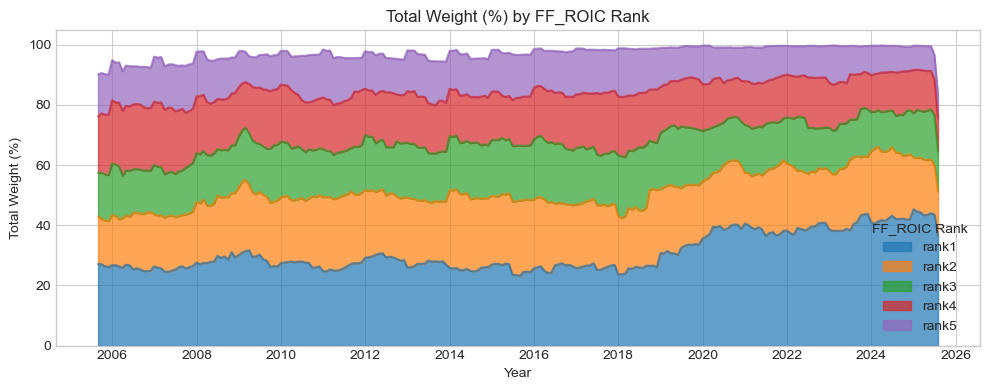

In [ ]:
# check number of securities and weights

variable = "FF_ROIC"
g = pd.DataFrame(
    df.groupby(["date", f"{variable}_rank_universe"])["P_SYMBOL"].agg("count")
).reset_index()
g = pd.pivot(g, index="date", columns=f"{variable}_rank_universe", values="P_SYMBOL")
g["total_secs"] = g.sum(axis=1)

g_weight = pd.DataFrame(
    df.groupby(["date", f"{variable}_rank_universe"])["Weight (%)"].agg("sum")
).reset_index()
g_weight = pd.pivot(
    g_weight, index="date", columns=f"{variable}_rank_universe", values="Weight (%)"
)
g_weight["total_weight (%)"] = g_weight.sum(axis=1)
g_weight.index = pd.to_datetime(g_weight.index)


# plot
cols_to_plot = [f"rank{i}" for i in range(1, 6)]

ax = g_weight[cols_to_plot].plot(kind="area", stacked=True, figsize=(10, 4), alpha=0.7)
ax.set_title(f"Total Weight (%) by {variable} Rank")
ax.set_ylabel("Total Weight (%)")
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlabel("Year")
ax.legend(title=f"{variable} Rank", loc="lower right")

plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.show()

-   2019 年から 2020 年にかけて、ROIC ランクが高位の weight が増加。rank1 は大型寄りになった。


#### 1. 【最重要・先行指標】実質時給 (Real Average Hourly Earnings)


In [ ]:
fred = Fred(api_key=FRED_API)
store_fred_database(
    db_path=FRED_DIR / "FRED.db",
    series_id_list=[
        "CES0500000031",  # Real Average Hourly Earnings
        "PCEC",  # Personal Consumption Expenditures
        "PAYEMS",  # All Employees: Total Nonfarm Payrolls
        "UNRATE",  # Unemployment Rate
        "UMCSENT",  # University of Michigan: Consumer Sentiment
        "INDRPO",  # Industrial Production Index - Total Index [INDPRO]
        "TCU",  # Capacity Utilization: Total Industry [TCU]
        "IPNCON",  # Industrial Production: Nondefense Capital Goods [IPNCONGD]
        "USTRADE",  # U.S. International Trade Balance [NETEXP]
    ],
)

NameError: name 'store_fred_database' is not defined